In [1]:
import sys
sys.path.append('./lib')

import numpy as np
import matplotlib.pyplot as plt

import pickle
from pathlib import Path

from model import PDFmodel

In [2]:
WEIGHTS_TOKEN = 'weights.h5'
def select_weight(epoch: int):
  return f"epoch_{int(epoch)}.{WEIGHTS_TOKEN}"

In [3]:
FIT_FOLDER = Path('./fits/fit_250417-01-L2-50000')
SERIALIZATION_FOLDER = FIT_FOLDER / 'serialization'
SERIALIZATION_FOLDER.mkdir(parents=True, exist_ok=True)

PLOT_FOLDER = FIT_FOLDER / 'plots'
PLOT_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
replicas_folders = [f for f in FIT_FOLDER.iterdir() if f.is_dir() and 'replica' in str(f)]
replicas_folders.sort()
data_by_replica = {replica_folder.name: np.load(replica_folder / 'data.npy')  for replica_folder in replicas_folders}
replicas = len(replicas_folders)

# For each replicas, load the epochs and data
replica_epochs_dict = {}
for replica_folder in replicas_folders:
  epochs = [f for f in replica_folder.iterdir() if f.is_file() and WEIGHTS_TOKEN in str(f)]
  epochs.sort()
  replica_epochs_dict[replica_folder.name] = epochs

In [5]:
# Find common epochs
common_epochs = set()
for replica, epochs in replica_epochs_dict.items():
  aux = set()
  for epoch in epochs:
    epoch_num = int(epoch.name.split('.')[0].split('_')[1])
    aux.add(epoch_num)
  
  if len(common_epochs) == 0:
    common_epochs = aux
  else:
    common_epochs.intersection_update(aux)

common_epochs = sorted(list(common_epochs))
print(f"Common epochs: {common_epochs}")

Common epochs: [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 50001]


In [6]:
class Distribution():
  def __init__(self, name):
    self.name = name
    self.__data = []
  
  def add(self, data):
    self.__data.append(data)

  def get_mean(self, axis=0):
    return np.mean(self.__data, axis=axis)
  
  def get_std(self, axis=0):
    return np.std(self.__data, axis=axis)
  
  def get_data(self):
    return np.array(self.__data)
  
  def set_data(self, data):
    self.__data = data

  def __str__(self):
    return f"{self.name}:\n{self.__data}"
  
  def __repr__(self):
    return self.__str__()
  
  def __len__(self):
    return len(self.__data)

  def __getitem__(self, key):
    return self.__data[key]

In [7]:
PDF = Distribution('PDF')
print(f'Loading {len(replicas_folders)} replicas...', end='\t')
for replica_path in replicas_folders:
    replica = replica_path.name
    last_epoch = replica_epochs_dict[replica][-1]

    model = PDFmodel.load_model(replica_path / 'config.json', last_epoch)
    PDF.add(model.predict().numpy().reshape(-1))
print('Done!')


Loading 100 replicas...	Done!


In [8]:
fk_grid = np.load('Tommaso/fk_grid.npy')
data = np.load('Tommaso/data.npy')
FK = np.load('Tommaso/FK.npy')
f_bcdms = np.load('Tommaso/f_bcdms.npy')
Cy = np.load('Tommaso/Cy.npy')
Cinv = np.linalg.inv(Cy)
y = FK @ f_bcdms

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(model.inputs.numpy().reshape(-1), PDF.get_mean(), label='Mean')
plt.fill_between(model.inputs.numpy().reshape(-1), PDF.get_mean() - PDF.get_std(), PDF.get_mean() + PDF.get_std(), alpha=0.5)
plt.plot(fk_grid, f_bcdms, label='True function')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$T_3$', fontsize=14)
plt.legend()
plt.savefig(PLOT_FOLDER / 'pdf_mean_std.png', dpi=300)
plt.close()

In [10]:
# Collect NTK distributions for each replica
if not any(SERIALIZATION_FOLDER.iterdir()):
  print('Data have not been serialized yet. Serializing now...')
  NTK_time = []
  frob_norm_time = []
  l2_norm_time = []
  for epoch in common_epochs:
    print(f"Epoch {epoch} / {common_epochs[-1]}")
    NTK_distribution = Distribution(f'NTK epoch {epoch}') # Each epoch contains a distribution of NTKs
    frob_norm_dist = Distribution(f'Frobenius norm epoch {epoch}')
    l2_norm_dist = Distribution(f'L2 norm epoch {epoch}')
    for replica_path in replicas_folders:
      model = PDFmodel.load_model(replica_path / 'config.json', replica_path / select_weight(epoch))
      NTK = model.compute_ntk()
      _, S, _ = np.linalg.svd(NTK, hermitian=True)
      frob_norm_dist.add(np.sqrt(np.sum([s**2 for s in S])))
      l2_norm_dist.add(S[0])
      NTK_distribution.add(NTK)

    NTK_time.append(NTK_distribution)
    frob_norm_time.append(frob_norm_dist)
    l2_norm_time.append(l2_norm_dist)
    pickle.dump(NTK_time, open(SERIALIZATION_FOLDER / 'NTK_time.pickle', 'wb'))
    pickle.dump(frob_norm_time, open(SERIALIZATION_FOLDER / 'frob_norm_time.pickle', 'wb'))
    pickle.dump(l2_norm_time, open(SERIALIZATION_FOLDER / 'l2_norm_time.pickle', 'wb'))
else:
  print('Data have already been serialized. Loading from disk...')
  NTK_time = pickle.load(open(SERIALIZATION_FOLDER / 'NTK_time.pickle', 'rb'))
  frob_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'frob_norm_time.pickle', 'rb'))
  l2_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'l2_norm_time.pickle', 'rb'))
  print('Done!')

Data have already been serialized. Loading from disk...
Done!


In [11]:
# Compute  \Delta\Theta_t = || \Theta_{t+1} - \Theta_t}||
Delta_ntk_t = []
for i in range(len(NTK_time) - 1):
  delta_ntk_dist = Distribution(f'Delta NTK {i}')
  for rep in range(replicas):
    delta_ntk = np.linalg.norm(NTK_time[i + 1][rep] - NTK_time[i][rep])
    delta_ntk_dist.add(delta_ntk)
  Delta_ntk_t.append(delta_ntk_dist)

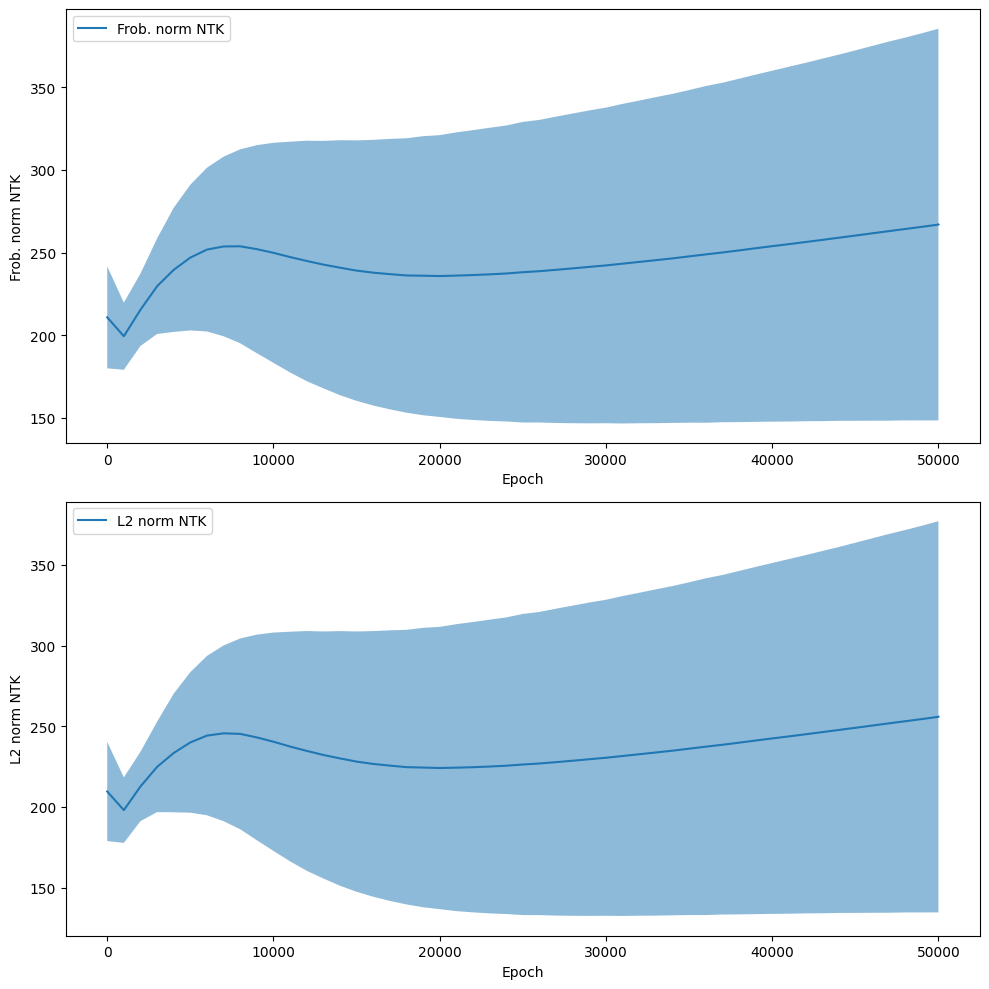

In [12]:
frob_means = np.array([frob.get_mean() for frob in frob_norm_time])
frob_stds = np.array([frob.get_std() for frob in frob_norm_time])
l2_means = np.array([l2.get_mean() for l2 in l2_norm_time])
l2_stds = np.array([l2.get_std() for l2 in l2_norm_time])

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(common_epochs, frob_means, label='Frob. norm NTK')
axs[0].fill_between(common_epochs, frob_means + frob_stds, frob_means - frob_stds, alpha=0.5)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Frob. norm NTK')
axs[0].legend()

axs[1].plot(common_epochs, l2_means, label='L2 norm NTK')
axs[1].fill_between(common_epochs, l2_means + l2_stds, l2_means - l2_stds, alpha=0.5)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 norm NTK')
axs[1].legend()

fig.tight_layout()
fig.savefig(PLOT_FOLDER / 'NTK_norms.png', dpi=300)

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_56707/4257832587.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


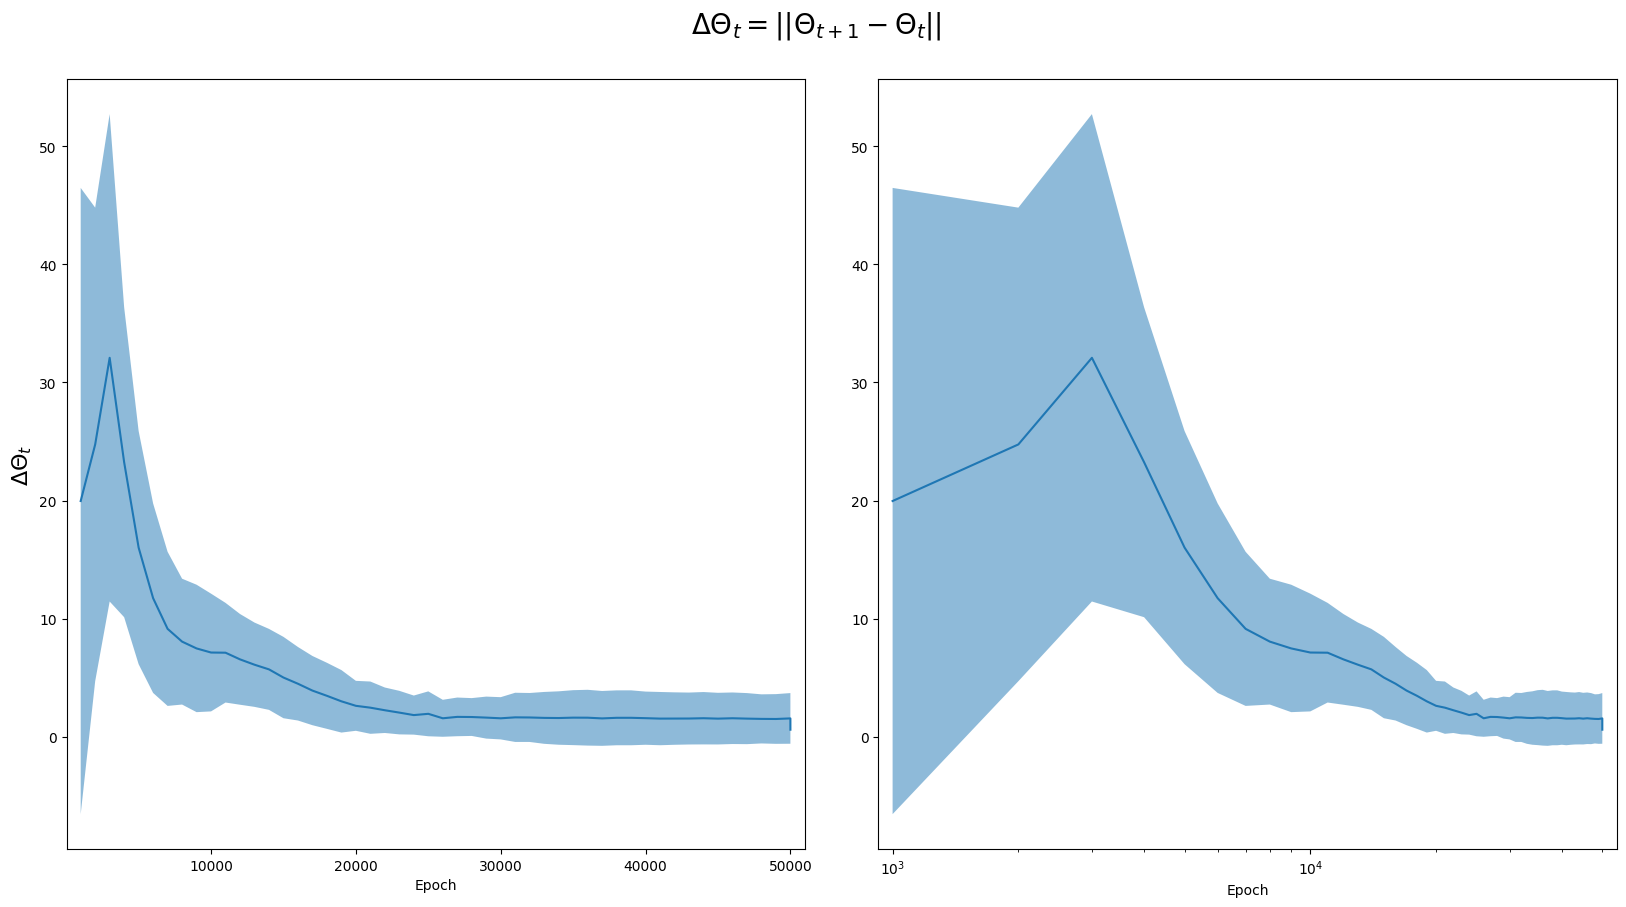

In [13]:
delta_ntk_means = np.array([delta.get_mean() for delta in Delta_ntk_t])
delta_ntk_stds = np.array([delta.get_std() for delta in Delta_ntk_t])

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

axs[0].plot(common_epochs[1:], delta_ntk_means, label='')
axs[0].fill_between(common_epochs[1:], delta_ntk_means + delta_ntk_stds, delta_ntk_means - delta_ntk_stds, alpha=0.5)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel(r'$\Delta \Theta_t$', fontsize=16)
axs[0].set_xmargin(0.02)

axs[1].plot(common_epochs[1:], delta_ntk_means, label='')
axs[1].fill_between(common_epochs[1:], delta_ntk_means + delta_ntk_stds, delta_ntk_means - delta_ntk_stds, alpha=0.5)
axs[1].set_xlabel('Epoch')
axs[1].set_xscale('log')
axs[1].set_xmargin(0.02)

fig.suptitle(r'$\Delta \Theta_t = || \Theta_{t+1} - \Theta_{t}||$', fontsize=20, y=0.95)
fig.tight_layout()
fig.savefig(PLOT_FOLDER / 'delta_ntk.png', dpi=300)

# Integrating the gradient flow

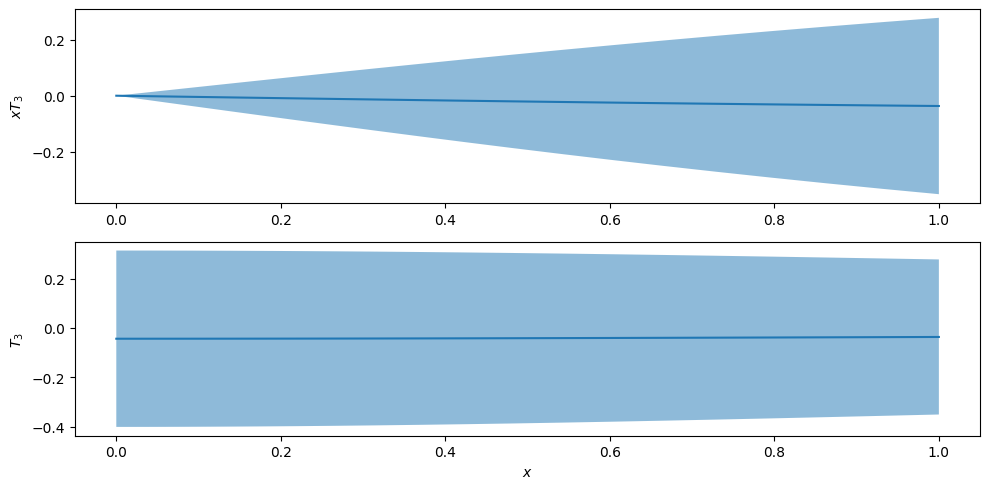

In [14]:
# Generating and ensemble of models
replicas = len(replicas_folders)
seed = 1423413
xT3_0 = Distribution('xT3 at initialisation')
T3_0 = Distribution('T3 at initialisation')
for rep in range(replicas):
  model = PDFmodel(
          dense_layer='Dense',
          input=fk_grid,
          outputs=1,
          architecture=[28,20],
          activations=['tanh', 'tanh'],
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed + rep)

  xT3_0.add(model.predict().numpy().reshape(-1))
  T3_0.add(model.predict().numpy().reshape(-1) / fk_grid)


# Plot the distribution at initialisation
fig, axs = plt.subplots(2,1, figsize=(10, 5))
axs[0].plot(fk_grid, xT3_0.get_mean(), label='Mean')
axs[0].fill_between(fk_grid, xT3_0.get_mean()  - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[0].set_ylabel(r'$xT_3$')

axs[1].plot(fk_grid, T3_0.get_mean(), label='Mean')
axs[1].fill_between(fk_grid, T3_0.get_mean()  - T3_0.get_std(), T3_0.get_mean() + T3_0.get_std(), alpha=0.5)
axs[1].set_ylabel(r'$T_3$')
axs[1].set_xlabel(r'$x$')
#_ = plt.title('Distribution at initialisation')

fig.tight_layout()
fig.savefig(PLOT_FOLDER / 'initialisation_distribution.png', dpi=300)

In [15]:
# Compute M and regularisation
reg1 = 0.0 # Integrability
reg2 = 0.0 # At one
reg3 = 0.0 # At zero
mat_reg_2 = np.zeros((FK.shape[1], FK.shape[1]))
mat_reg_3 = np.zeros((FK.shape[1], FK.shape[1]))
mat_reg_2[-1,-1] = 1
mat_reg_3[0,0] = 1
M = FK.T @ Cinv @ FK + reg1 * np.eye(FK.shape[1]) + reg2 * mat_reg_2 + reg3 * mat_reg_3
U_M, sigma, Vh_M = np.linalg.svd(M, hermitian=True)

print('The first rank-order at which right- and left-singular vectors are different is: ', end='')
for r_idx in range(U_M.shape[0]):
  if not np.allclose(U_M[:,r_idx], Vh_M.T[:,r_idx]):
    print(f"{r_idx}")
    break

The first rank-order at which right- and left-singular vectors are different is: 22


In [16]:
r = 20 # Number of singular values to keep
print(np.allclose(U_M[:,r-1], Vh_M.T[:,r-1]))
u = U_M
u_tilde = u @ np.diag(np.sqrt(sigma))

True


In [17]:
# Compute H_tilde from the decomposition of M
ntk_dist = NTK_time[-1] # Choose the last common epoch for the NTK
v_dist = Distribution('Singular vectors H_tilde')
h_dist = Distribution('Singular values H_tilde')
b_dist = Distribution('b')
w_dist = Distribution('w')
w_bar_dist = Distribution('w_bar')
cuts_list = []

for rep in range(replicas):
  ntk = ntk_dist[rep]
  y = data_by_replica[f'replica_{rep+1}']

  # Compute b
  b_dist.add(ntk.numpy() @ FK.T @ Cinv @ y)

  H_tilde = np.zeros((r,r))
  for i in range(r):
      for j in range(r):
          H_tilde[i,j] = np.dot(u_tilde[:,i], ntk.numpy() @ u_tilde[:,j])

  U_h_tilde, h, Vh_h_tilde = np.linalg.svd(H_tilde, hermitian=True)
  print(f'The first rank-order at which right- and left-singular vectors are different for replicas {rep} is: ', end='')
  for r_idx in range(U_h_tilde.shape[0]):
    if not np.allclose(U_h_tilde[:,r_idx], Vh_h_tilde.T[:,r_idx]):
      print(f"{r_idx}")
      cuts_list.append(r_idx-3)
      break
    if r_idx == U_h_tilde.shape[0] - 1:
      print(f"{r_idx}")
      cuts_list.append(r_idx)
    
  
  h_dist.add(h)
  w_dist.add(np.einsum('im, ai -> ma', U_h_tilde, u_tilde[:, :r] / sigma[:r]))
  w_bar_dist.add(np.einsum('im, ai -> ma', U_h_tilde, u_tilde[:, :r]))

The first rank-order at which right- and left-singular vectors are different for replicas 0 is: 8
The first rank-order at which right- and left-singular vectors are different for replicas 1 is: 7
The first rank-order at which right- and left-singular vectors are different for replicas 2 is: 10
The first rank-order at which right- and left-singular vectors are different for replicas 3 is: 11
The first rank-order at which right- and left-singular vectors are different for replicas 4 is: 8
The first rank-order at which right- and left-singular vectors are different for replicas 5 is: 10
The first rank-order at which right- and left-singular vectors are different for replicas 6 is: 8
The first rank-order at which right- and left-singular vectors are different for replicas 7 is: 7
The first rank-order at which right- and left-singular vectors are different for replicas 8 is: 8
The first rank-order at which right- and left-singular vectors are different for replicas 9 is: 9
The first rank-or

In [18]:
Fm_0 = Distribution('Fm_0')
Bm = Distribution('Bm')
f0_parallel_dist = Distribution('f0_perp')
for rep in range(replicas):
  Fm_0.add(w_bar_dist[rep][:cuts_list[rep]] @ xT3_0[rep])
  Bm.add(w_bar_dist[rep][:cuts_list[rep]] @ b_dist[rep])
  f0_perp = w_dist[rep].T[:,:cuts_list[rep]] @ Fm_0[rep]
  f0_parallel_dist.add(xT3_0[rep] - f0_perp)

In [19]:
def compute_xft(t):
  xft = Distribution('xft')
  for rep in range(replicas):
    Fm_t = np.array([np.exp(-h_dist[rep][m] * t) * Fm_0[rep][m] + (1 - np.exp(-h_dist[rep][m]*t)) * Bm[rep][m] / h_dist[rep][m] for m in range(cuts_list[rep])])
    xft.add(w_dist[rep].T[:,:cuts_list[rep]] @ Fm_t + f0_parallel_dist[rep])
  return xft

def compute_ft(t):
  ft = Distribution('ft')
  for rep in range(replicas):
    Fm_t = np.array([np.exp(-h_dist[rep][m] * t) * Fm_0[rep][m] + (1 - np.exp(-h_dist[rep][m]*t)) * Bm[rep][m] / h_dist[rep][m] for m in range(cuts_list[rep])])
    ft.add((w_dist[rep].T[:,:cuts_list[rep]] @ Fm_t + f0_parallel_dist[rep]) / fk_grid)
  return ft

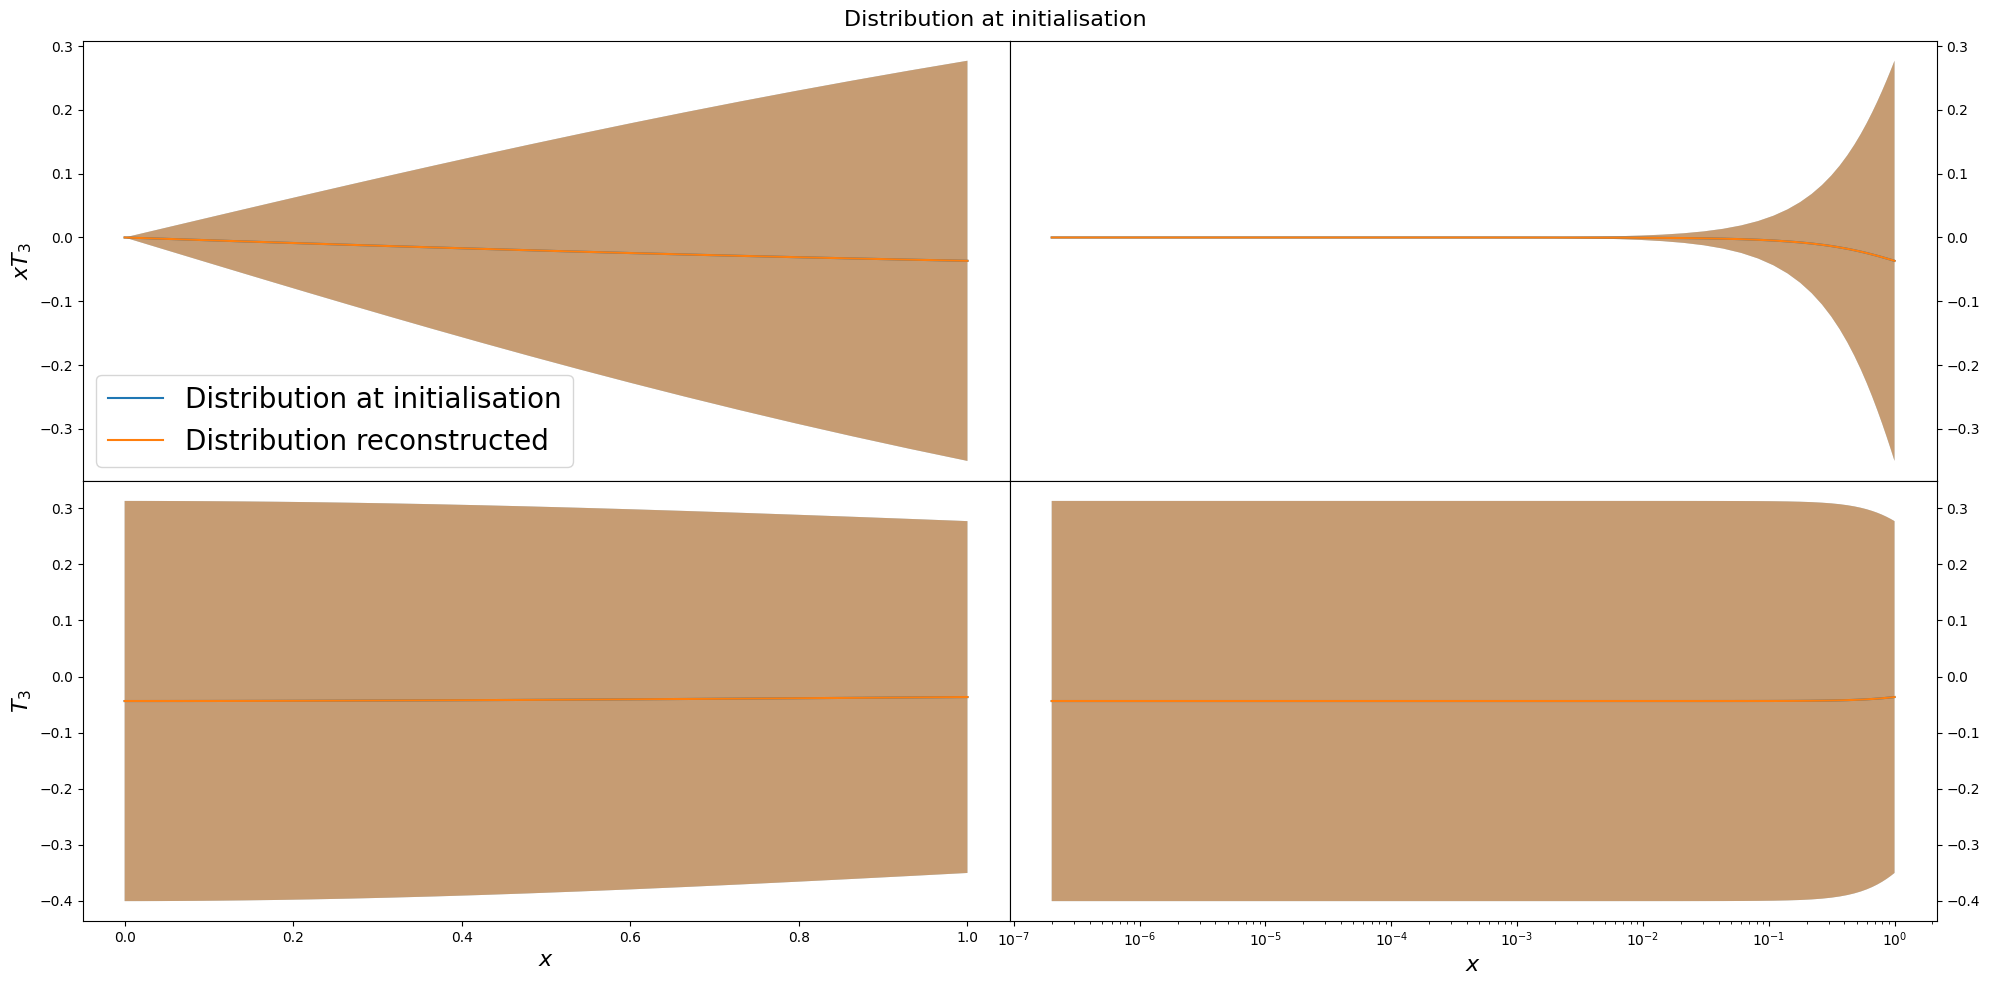

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
xft = compute_xft(0.0)
ft = compute_ft(0.0)

# xf linaer
axs[0,0].plot(fk_grid, xT3_0.get_mean(), label='Distribution at initialisation')
axs[0,0].fill_between(fk_grid, xT3_0.get_mean() - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[0,0].plot(fk_grid, xft.get_mean(), label='Distribution reconstructed')
axs[0,0].fill_between(fk_grid, xft.get_mean() - xft.get_std(), xft.get_mean() + xft.get_std(), alpha=0.5)

# xf log
axs[0,1].plot(fk_grid, xT3_0.get_mean())
axs[0,1].fill_between(fk_grid, xT3_0.get_mean() - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[0,1].plot(fk_grid, xft.get_mean())
axs[0,1].fill_between(fk_grid, xft.get_mean() - xft.get_std(), xft.get_mean() + xft.get_std(), alpha=0.5)
axs[0,1].set_xscale('log')
axs[0,1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# f linear
axs[1,0].plot(fk_grid, T3_0.get_mean())
axs[1,0].fill_between(fk_grid, T3_0.get_mean() - T3_0.get_std(), T3_0.get_mean() + T3_0.get_std(), alpha=0.5)
axs[1,0].plot(fk_grid, ft.get_mean())
axs[1,0].fill_between(fk_grid, ft.get_mean() - ft.get_std(), ft.get_mean() + ft.get_std(), alpha=0.5)

# f log
axs[1,1].plot(fk_grid, T3_0.get_mean())
axs[1,1].fill_between(fk_grid, T3_0.get_mean() - T3_0.get_std(), T3_0.get_mean() + T3_0.get_std(), alpha=0.5)
axs[1,1].plot(fk_grid, ft.get_mean())
axs[1,1].fill_between(fk_grid, ft.get_mean() - ft.get_std(), ft.get_mean() + ft.get_std(), alpha=0.5)
axs[1,1].set_xscale('log')
axs[1,1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

axs[0,0].set_ylabel(r'$xT_3$', fontsize=16)
axs[1,1].set_xlabel(r'$x$', fontsize=16)
axs[1,0].set_xlabel(r'$x$', fontsize=16)
axs[1,0].set_ylabel(r'$T_3$', fontsize=16)

axs[0,0].legend(fontsize=20)

fig.suptitle('Distribution at initialisation', fontsize=16)
fig.tight_layout()
fig.savefig(PLOT_FOLDER / 'distribution_initialisation_reconstructed.png', dpi=300)

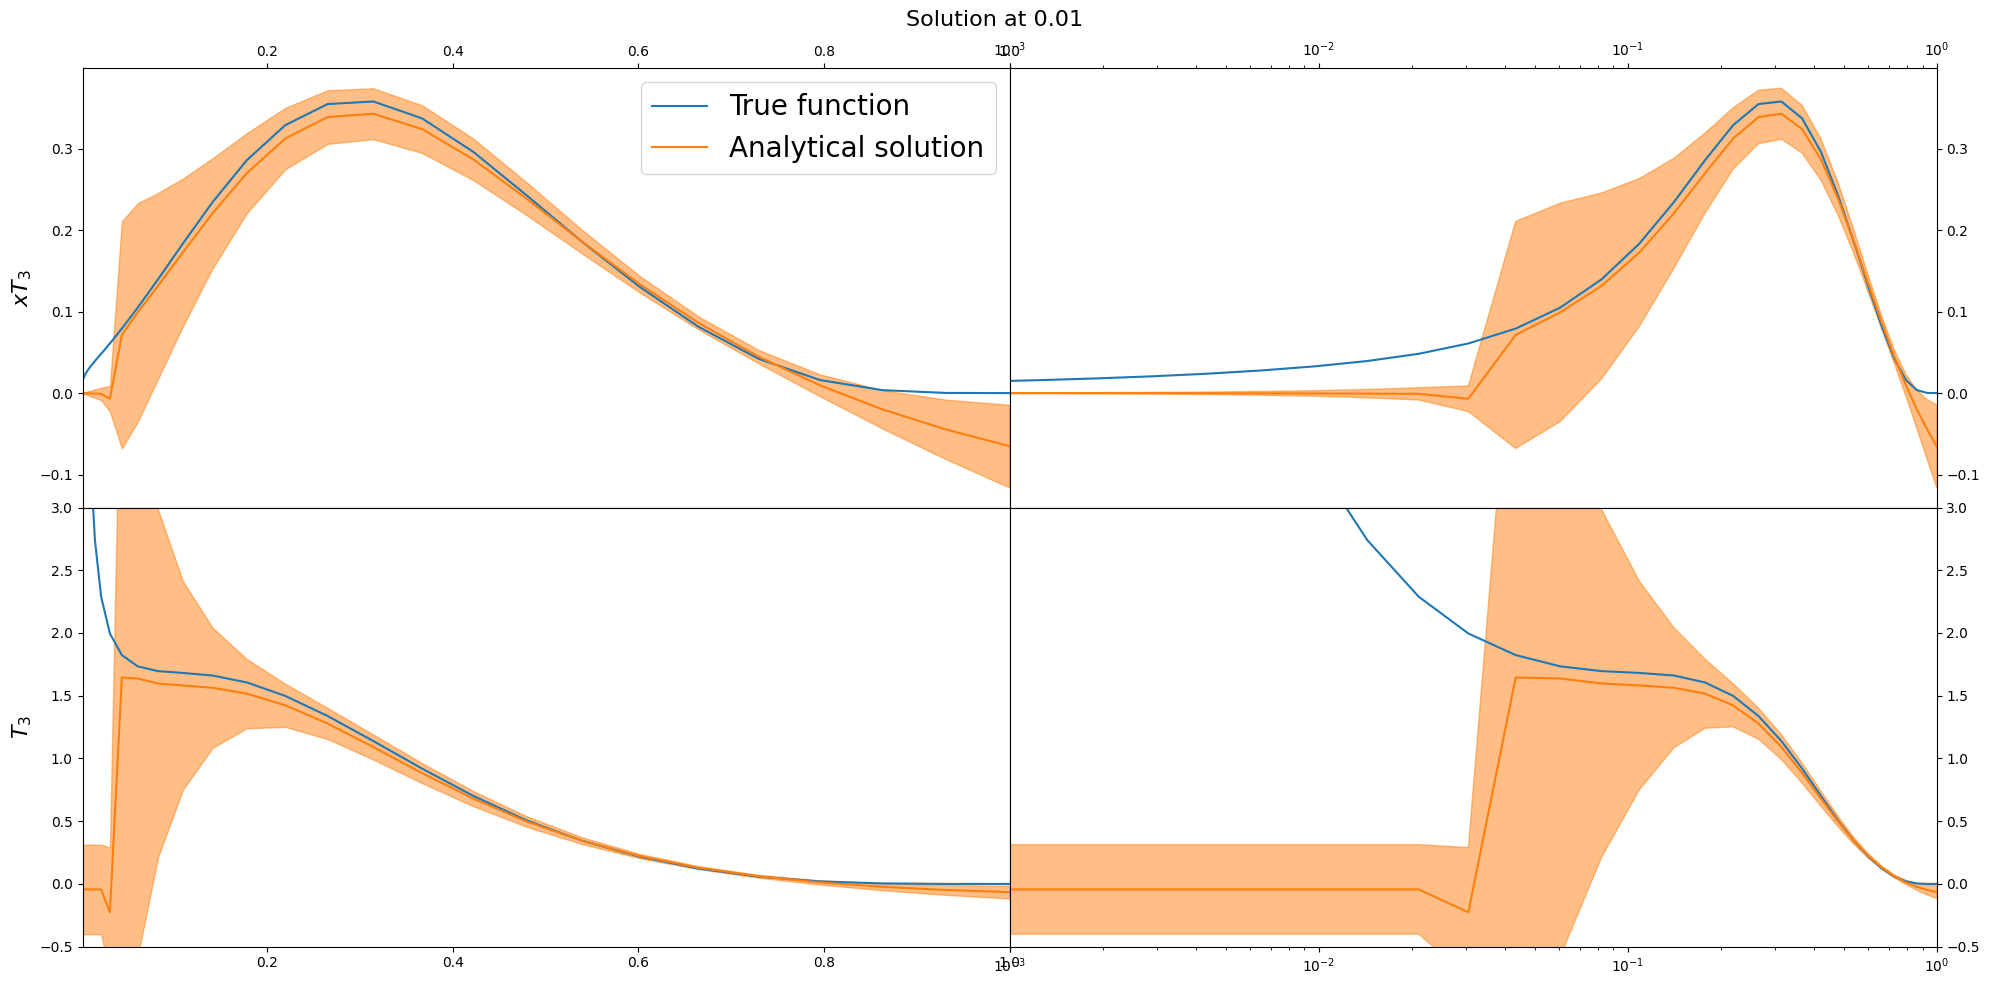

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
t = 1.e-2
xft = compute_xft(t)
ft = compute_ft(t)

axs[0,0].plot(fk_grid, f_bcdms, color='C0', label='True function')
axs[0,0].plot(fk_grid, xft.get_mean(), color='C1', label='Analytical solution')
axs[0,0].fill_between(fk_grid, xft.get_mean() - xft.get_std(), xft.get_mean() + xft.get_std(), alpha=0.5, color='C1')
axs[0,0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0,0].legend(fontsize=20)
axs[0,0].set_xlim(1.e-3, 1)
axs[0,0].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

axs[0,1].plot(fk_grid, f_bcdms, color='C0', label='True function')
axs[0,1].plot(fk_grid, xft.get_mean(), color='C1')
axs[0,1].fill_between(fk_grid, xft.get_mean() - xft.get_std(), xft.get_mean() + xft.get_std(), alpha=0.5, color='C1')
axs[0,1].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
axs[0,1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[0,1].set_xlim(1.e-3, 1)
axs[0,1].set_xscale('log')

axs[1,0].plot(fk_grid, f_bcdms / fk_grid, color='C0', label='True function')
axs[1,0].plot(fk_grid, ft.get_mean(), color='C1')
axs[1,0].fill_between(fk_grid, ft.get_mean() - ft.get_std(), ft.get_mean() + ft.get_std(), alpha=0.5, color='C1')
axs[1,0].set_ylabel(r'$T_3$', fontsize=16)
axs[1,0].set_xlim(1.e-3, 1)
axs[1,0].set_ylim(-0.5, 3)

axs[1,1].plot(fk_grid, f_bcdms / fk_grid, color='C0', label='True function')
axs[1,1].plot(fk_grid, ft.get_mean(), color='C1')
axs[1,1].fill_between(fk_grid, ft.get_mean() - ft.get_std(), ft.get_mean() + ft.get_std(), alpha=0.5, color='C1')
axs[1,1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1,1].set_xlim(1.e-3, 1)
axs[1,1].set_ylim(-0.5, 3)
axs[1,1].set_xscale('log')

fig.suptitle(f'Solution at {t}', fontsize=16)
fig.tight_layout()
fig.savefig(PLOT_FOLDER / 'analytical_solution.png', dpi=300)

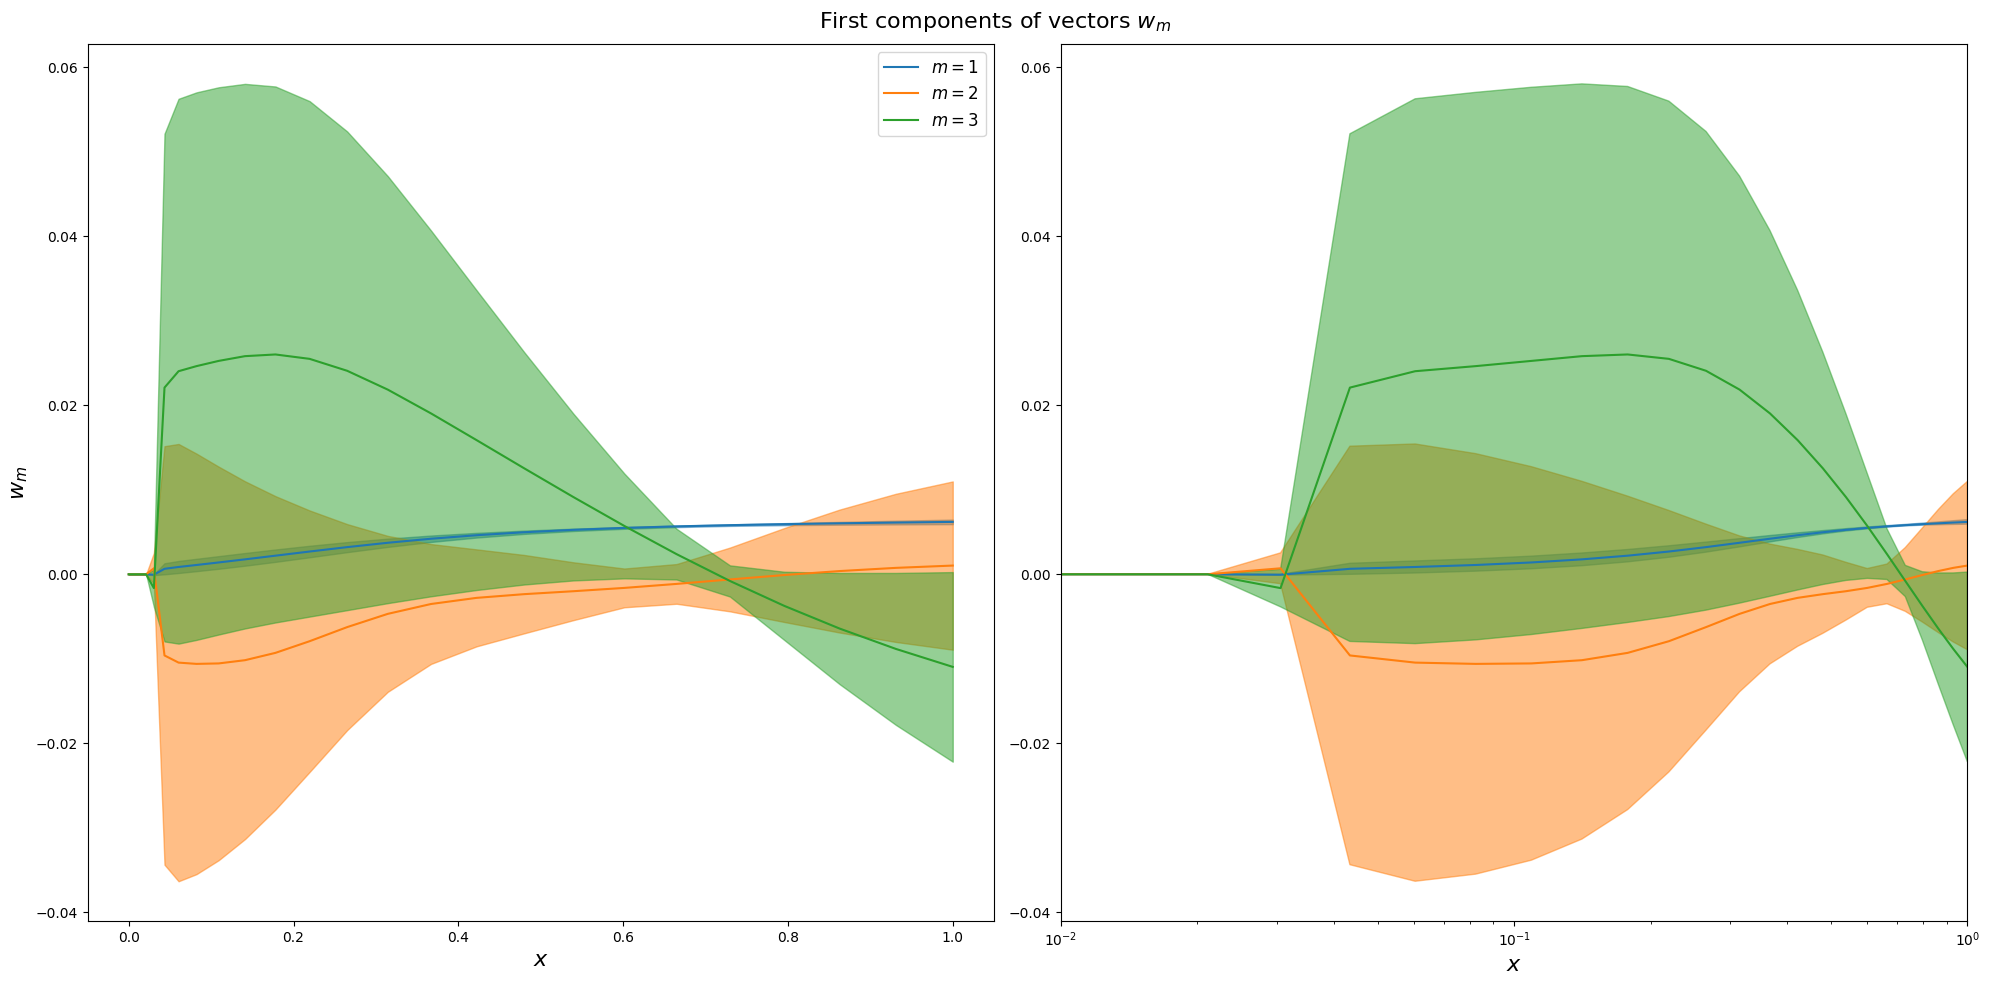

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
colors = ['C0', 'C1', 'C2']

components = 3
for c in range(components):
  mean = w_dist.get_mean(axis=0)[c]
  std = w_dist.get_std(axis=0)[c]

  axs[0].plot(fk_grid, mean, label=r'$m=$' + f"{c+1}", color=colors[c])
  axs[0].fill_between(fk_grid, mean - std, mean + std, alpha=0.5, color=colors[c])

  axs[0].legend(fontsize=12)
  axs[0].set_xlabel(r'$x$', fontsize=16)
  axs[0].set_ylabel(r'$w_m$', fontsize=16)

  axs[1].plot(fk_grid, mean, color=colors[c])
  axs[1].fill_between(fk_grid, mean - std, mean + std, alpha=0.5, color=colors[c])

  axs[1].set_xscale('log')
  axs[1].set_xlabel(r'$x$', fontsize=16)
  axs[1].set_xlim(1.e-2, 1)

  fig.suptitle(r'First components of vectors $w_m$', fontsize=16)

fig.tight_layout()
fig.savefig(PLOT_FOLDER / 'w_components.png', dpi=300)

In [23]:
# Save and convert the notebook to HTML
import os

# Convert the notebook to HTML
def convert_to_html(notebook_filename):
    os.system(f"jupyter nbconvert --to html {notebook_filename} --output-dir {FIT_FOLDER} --output analysis")
    print(f"Notebook converted to HTML: {notebook_filename.replace('.ipynb', '.html')}")

In [24]:
convert_to_html('analyse.ipynb')
print("Notebook saved and converted to HTML.")

[NbConvertApp] Converting notebook analyse.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 1156018 bytes to fits/fit_250417-01-L2-50000/analysis.html


Notebook converted to HTML: analyse.html
Notebook saved and converted to HTML.
